# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


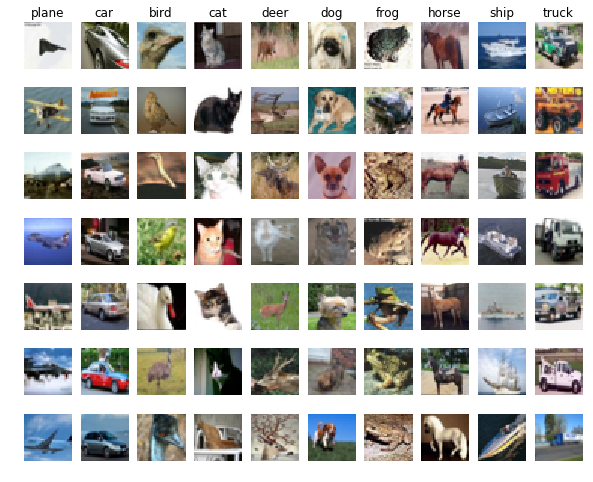

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 49000
num_validation = 1000
num_test = 1000

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


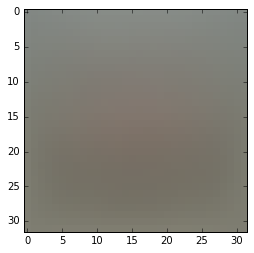

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

print(X_train.shape, X_val.shape, X_test.shape)

(3073, 49000) (3073, 1000) (3073, 1000)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# for 5 times, generate a random SVM weight matrix of small numbers
for _ in range(5):
    W = np.random.randn(10, 3073) * 0.0001 
    loss, grad = svm_loss_naive(W=W, X=X_train, y=y_train, reg=0.00001)
    print('loss: %f' % (loss, ))

loss: 9.119617
loss: 9.386116
loss: 8.672732
loss: 8.803249
loss: 9.124440


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_train, y_train, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -9.862215029343702 analytic: -9.866140974593904, relative error: 0.0001990001219269718
numerical: -3.608098674412474 analytic: -3.6129629854226697, relative error: 0.0006736282335396719
numerical: -42.9183494725649 analytic: -42.9188349816745, relative error: 5.6561630334078305e-06
numerical: 2.487557437991228 analytic: 2.4901298433985732, relative error: 0.000516787267244124
numerical: 16.244912069840467 analytic: 16.244214937525943, relative error: 2.145740371436671e-05
numerical: 6.531749873506242 analytic: 6.530383080383107, relative error: 0.00010463782048154494
numerical: 42.747317860225564 analytic: 42.749097730944904, relative error: 2.0818074150035893e-05
numerical: -2.451984923901307 analytic: -2.4504977759266877, relative error: 0.00030334588935345303
numerical: -4.519017974757844 analytic: -4.521335107871784, relative error: 0.00025631002381889216
numerical: 30.512857024334036 analytic: 30.510036084964632, relative error: 4.6227558636900556e-05


### Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** Since the SVM loss is not strictly differentiable, it can happen the gradiend is calculated in a point where the SVM function is not differentiable. In that point the numerical value can be calculated though.

In [54]:
mya = np.array([-1,2,3, -4,0, 6])

print(np.reshape(mya,(-1,1)))


[[-1]
 [ 2]
 [ 3]
 [-4]
 [ 0]
 [ 6]]


In [68]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print('Naive loss: {} computed in {}'.format(loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print('Vectorized loss: {} computed in {}'.format(loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: {} (same loss:{})'.format(loss_naive - loss_vectorized,(loss_naive - loss_vectorized)<1e-10))

Naive loss: 9.124440473141847 computed in 5.012922763824463
Vectorized loss: 9.124440473141775 computed in 0.3589000701904297
difference: 7.283063041541027e-14 (same loss:True)


In [91]:
loss_vectorized, _ = svm_loss_vectorized(W, X_train, y_train, 0.00001)

(3073, 49000)
(10, 3073)
(3073, 10)


In [93]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
#print('Naive gradient: {}'.format(np.sum(grad_naive)))
#print('Vectorized gradient: {}'.format(np.sum(grad_vectorized)))
print('Difference: %f' % difference)

Naive loss and gradient: computed in 5.203739s
(3073, 49000)
(10, 3073)
(10, 3073)
Vectorized loss and gradient: computed in 0.740081s
Naive gradient: 1.8895661924034357e-07
Vectorized gradient: 1.888984115794301e-07
Difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [156]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1000, verbose=True)
toc = time.time()
print('That took {}'.format(toc - tic))

iteration 0 / 1000: loss 784.786058
iteration 100 / 1000: loss 287.564375
iteration 200 / 1000: loss 108.161252
iteration 300 / 1000: loss 42.673880
iteration 400 / 1000: loss 18.489067
iteration 500 / 1000: loss 10.415315
iteration 600 / 1000: loss 6.934917
iteration 700 / 1000: loss 6.038796
iteration 800 / 1000: loss 5.386239
iteration 900 / 1000: loss 5.395513
That took 10.846415042877197


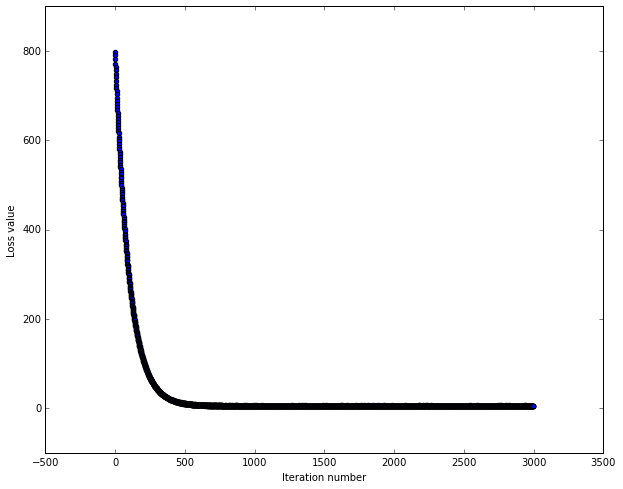

In [117]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.scatter(range(len(loss_hist)),loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

(4, 10)

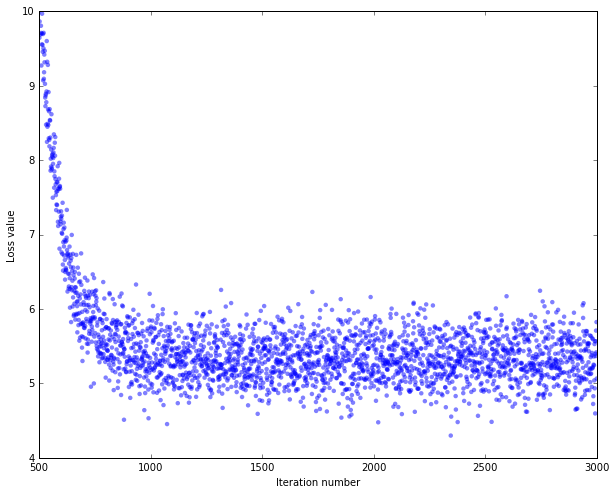

In [140]:
#zoom on the last part
plt.scatter(range(len(loss_hist)),loss_hist, alpha=0.5, edgecolor='None')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.xlim(500,3000)
plt.ylim(4,10)

In [146]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368367
validation accuracy: 0.364000


In [188]:
import copy
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
iterations=50
for iteration in range(iterations):
    svm.W = np.random.randn(np.max(y_train) + 1, X_train.shape[0]) * 0.001
    learning_rate = np.random.uniform(low=learning_rates[0], high=learning_rates[1]) 
    reg_strength = np.random.uniform(low=regularization_strengths[0], high=regularization_strengths[1])
    loss_hist = svm.train(X_train, y_train, 
                          learning_rate=learning_rate, 
                          reg=reg_strength,
                          num_iters=1000, 
                          verbose=False)
    y_train_pred = svm.predict(X_train)
    y_val_pred = svm.predict(X_val)   
    accuracy_train = np.mean(y_train_pred==y_train)   
    accuracy_val = np.mean(y_val_pred==y_val)
    if accuracy_val>best_val:
        best_val = accuracy_val
        best_svm = copy.copy(svm)
    results[(learning_rate,reg_strength)] = (accuracy_train,accuracy_val)
    print('{} - rl={} - reg={} - acc_t={} -  acc_v={}'.format(iteration,
                                                              round(learning_rate,6),
                                                               round(reg_strength,0),
                                                               round(accuracy_train,3),
                                                               round(accuracy_val,3)))
    #print(iterations-iteration,end=',')
print()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
#for lr, reg in sorted(results):
#    train_accuracy, val_accuracy = results[(lr, reg)]
#    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

0 - rl=8e-06 - reg=84445.0 - acc_t=0.212 -  acc_v=0.208


/home/godzy/data_science/cs231n/assignment1/cs231n/classifiers/linear_svm.py:138: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
/home/godzy/data_science/cs231n/assignment1/cs231n/classifiers/linear_svm.py:138: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)
/home/godzy/data_science/cs231n/assignment1/cs231n/classifiers/linear_svm.py:83: RuntimeWarning: overflow encountered in subtract
  margins = scores - correct_class_scores.reshape(-1, 1) + 1
/home/godzy/data_science/cs231n/assignment1/cs231n/classifiers/linear_svm.py:139: RuntimeWarning: overflow encountered in multiply
  dW = dW + reg * W
/home/godzy/data_science/cs231n/assignment1/cs231n/classifiers/linear_svm.py:83: RuntimeWarning: invalid value encountered in subtract
  margins = scores - correct_class_scores.reshape(-1, 1) + 1
/home/godzy/data_science/cs231n/assignment1/cs231n/classifiers/linear_svm.py:90: RuntimeWarning: invalid value encountered

1 - rl=4.4e-05 - reg=71497.0 - acc_t=0.1 -  acc_v=0.087
2 - rl=4.8e-05 - reg=77778.0 - acc_t=0.1 -  acc_v=0.087
3 - rl=2.6e-05 - reg=65044.0 - acc_t=0.113 -  acc_v=0.119
4 - rl=1.8e-05 - reg=77637.0 - acc_t=0.178 -  acc_v=0.172
5 - rl=4.8e-05 - reg=50851.0 - acc_t=0.117 -  acc_v=0.135
6 - rl=2.5e-05 - reg=60018.0 - acc_t=0.09 -  acc_v=0.076
7 - rl=8e-06 - reg=95712.0 - acc_t=0.182 -  acc_v=0.189
8 - rl=4.6e-05 - reg=75146.0 - acc_t=0.1 -  acc_v=0.087
9 - rl=3.6e-05 - reg=99131.0 - acc_t=0.1 -  acc_v=0.087
10 - rl=2.3e-05 - reg=90833.0 - acc_t=0.093 -  acc_v=0.092
11 - rl=3e-06 - reg=91902.0 - acc_t=0.18 -  acc_v=0.206
12 - rl=1.9e-05 - reg=88737.0 - acc_t=0.07 -  acc_v=0.071
13 - rl=3.3e-05 - reg=51478.0 - acc_t=0.103 -  acc_v=0.1
14 - rl=2.9e-05 - reg=89154.0 - acc_t=0.054 -  acc_v=0.058
15 - rl=4.5e-05 - reg=58812.0 - acc_t=0.099 -  acc_v=0.111
16 - rl=3e-05 - reg=58394.0 - acc_t=0.078 -  acc_v=0.083
17 - rl=3.5e-05 - reg=66286.0 - acc_t=0.062 -  acc_v=0.061
18 - rl=2.1e-05 - reg=558

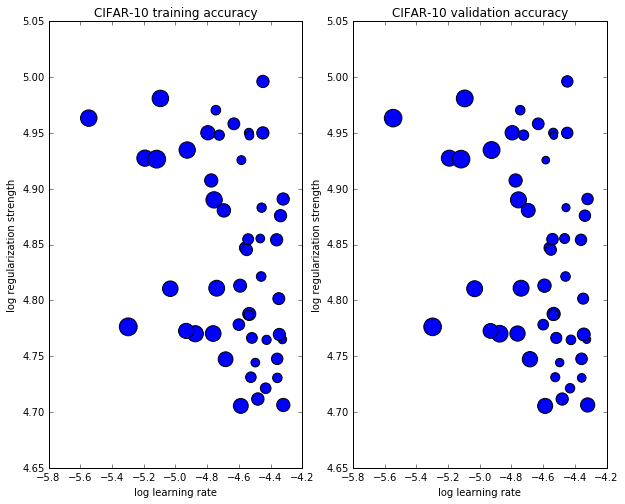

In [189]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
sz = [results[x][0]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,1)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
sz = [results[x][1]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,2)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

In [190]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.212000


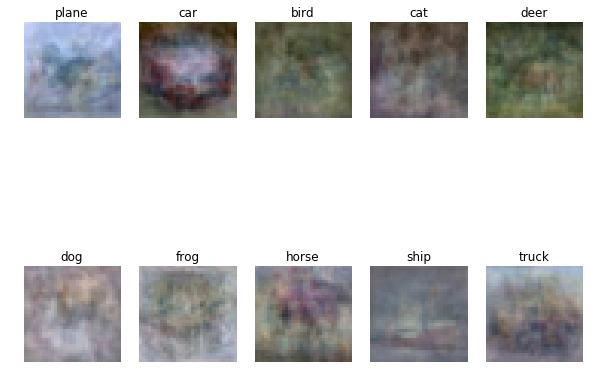

In [191]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** 
The images are like filters/masks to apply to the image to be classified.
They can give more or less importance to different areas/colors of the image in order to calculate different scopes.
They act like image templates of the different categories.